## EDA



Import packages



In [1]:
import os
os.chdir("utils")

# Out[1]:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns
%matplotlib inline
import os
%load_ext autoreload
%autoreload 2

from implementations import reg_logistic_regression
from helpers import sigmoid
from cross_validation import accuracy, f1_score

:results:
  # Out[2]:
  :end:

Read the training data



In [1]:
train = pd.read_csv("../data/train.csv")

:results:
  # Out[3]:
  :end:

Replace the missing values by np.nan, and try list-wise deletion



In [1]:
cc = train.replace(to_replace=-999, value=np.nan).dropna()
cc.shape

:results:
  # Out[4]:
  : (68114, 32)
  :end:

We are ultimately left with a sample of 68 thousand rows, which should be an adequate sample size for prediction.
  We also want to investigate the balance of the outcome. First, subset and coerce the label vector to numeric



In [1]:
y = np.where(np.asarray(cc.loc[:, 'Prediction']) == 's', 1, 0)
y

:results:
  # Out[5]:
  : array([1, 0, 1, ..., 1, 1, 0])
  :end:

Plot the outcome variable



:results:
  # Out[6]:
  : <BarContainer object of 2 artists>
  
  :end:

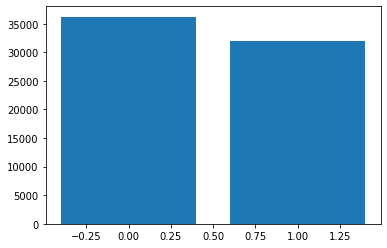

In [1]:
unique, counts = np.unique(y, return_counts=True)
plt.bar(unique, counts)

We have approximately 30 thousand labels that are classified as 1, and we see that the outcome is balanced among 1s 
  ans 0s. Hence, we are able to evaluate the model on a balanced outcome.

Now we create the feature set. Drop the Prediction and the id columns to create the feature matrix



In [1]:
c = ['Id', 'Prediction']
X = cc.drop(columns=c)

:RESULTS:
  # Out[93]:
  :END:

Standardize the feature set for prediction



In [1]:
X_standardized = (X - X.mean(axis=0)) / X.std(axis=0)

:RESULTS:
  # Out[94]:
  :END:

Augment the dataset with 1s, for the intercept of the model.



In [1]:
X_model = pd.concat([
    pd.DataFrame(
        np.ones((X_standardized.shape[0], 1)), 
        columns=['beta0'], 
        index=X_standardized.index
    ),
    X_standardized
], axis=1)
X_model.iloc[:5, :5]

:RESULTS:
  # Out[95]:
  #+BEGIN_EXAMPLE
    beta0  DER_mass_MMC  DER_mass_transverse_met_lep  DER_mass_vis  DER_pt_h
    0     1.0      0.257669                     0.532831      0.474607 -1.093446
    5     1.0     -0.544384                    -0.706345     -0.475040  0.064383
    6     1.0      0.426949                    -0.208398      0.719029 -0.069451
    11    1.0     -0.132872                    -0.812491     -0.068375 -1.056286
    23    1.0      0.307232                    -1.123057      0.812305  0.820829
  #+END_EXAMPLE
  :END:

To conduct the same data-preprocessing on the test set, we prepare a function for these operations



In [1]:
def missing_data_handling(raw_sample, method="cc", imp_percentage=None):
    """
    Handle missing data for the raw sample

    Parameters
    ----------
    raw_sample: Numpy array
        Sample to be handled.
    method: String
        Missing data handler. Must be one of 'cc' (for complete case)
        or 'si' (for simple, median imputation).
    imp_percentage: Float
        If method is 'si' and imp_percentage is specified, then only
        the features with proportions of missing data corresponding to
        imp_percentage will be imputed, the rest are removed. 
        If None (as default), all columns with missing data are handled
        using imputation.

    Returns
    -------
    raw_sample: Numpy array
        Sample with missing data handled.
    """
    assert method in ['cc', ''], "Parameter method must be one of 'cc', 'si'"
    
    if method == 'cc':
        raw_sample = raw_sample.replace(to_replace=-999, value=np.nan).dropna()
    elif method == 'si':
        pass

    return raw_sample

def conduct_data_preparation(raw_sample, missing_method="cc", 
                             include_outcome=True):
    """Missing data handling and data subsetting."""
    ## Drop nas
    sample = missing_data_handling(
        raw_sample,
        method=missing_method
    )
    ## Subset outcome 
    y = None
    if include_outcome:
        y = np.where(np.asarray(cc.loc[:, 'Prediction']) == 's', 1, 0)
    c = ['Id', 'Prediction']
    X = cc.drop(columns=c)

    return X, y


def prepare_features(X, include_outcome=True):
    """Missing data handling, data subsettting, and augmentation."""
    ## Standardize sample
    X_standardized = (X - X.mean(axis=0)) / X.std(axis=0)
    ## Make prediction data
    X_model = pd.concat([
        pd.DataFrame(
            np.ones((X_standardized.shape[0], 1)), 
            columns=['beta0'], 
            index=X_standardized.index
        ),
        X_standardized
    ], axis=1)

    return X_model

:RESULTS:
  # Out[155]:
  :END:

In [1]:
X, y = conduct_data_preparation(train)

:RESULTS:
  # Out[156]:
  :END:

### Exploring the distributions of the variables



:RESULTS:
   # Out[98]:
   
   :END:

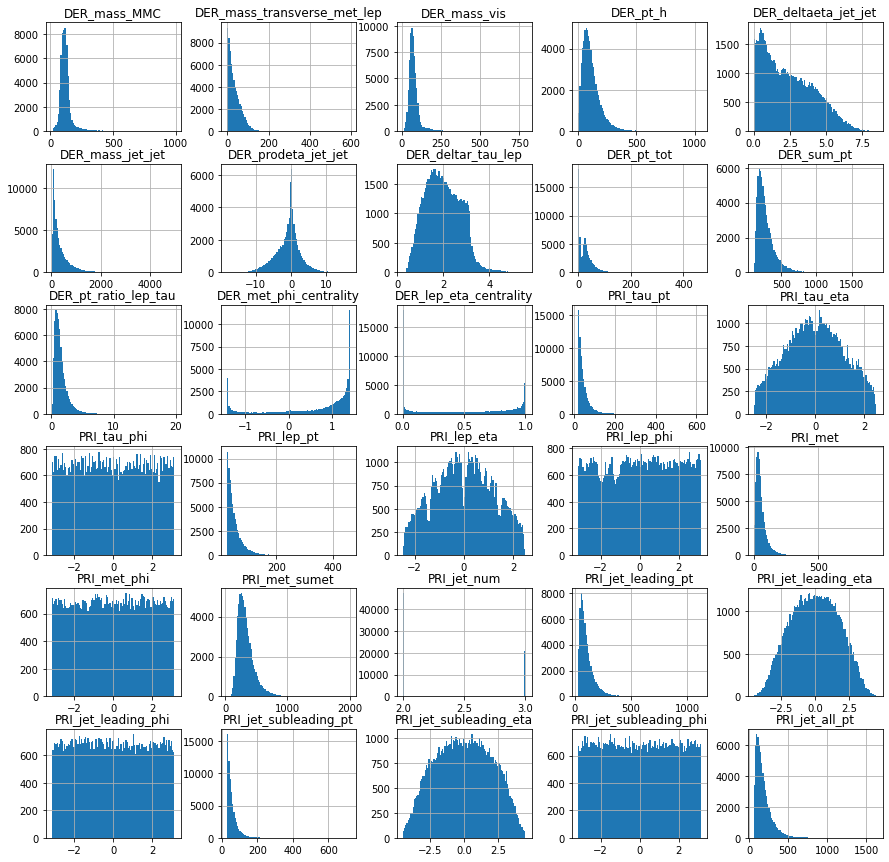

In [1]:
f = X.hist(figsize=(15, 15), bins = 100)

:RESULTS:
   # Out[99]:
   : <AxesSubplot:>
   
   :END:

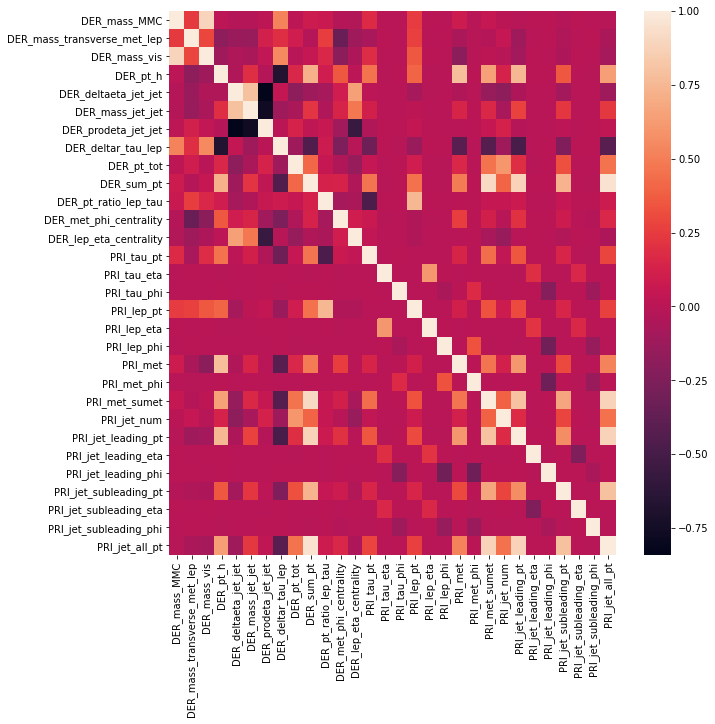

In [1]:
corr = X.corr()
f, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(
    corr, 
    xticklabels=corr.columns.values,
    yticklabels=corr.columns.values,
    ax=ax
)

## Training



Define a function similar to that in implementations, but constructed to work with dataframes



In [1]:
def split_data(x, y, ratio, shuffle=True, seed=1):
    """Split data into train and test set."""

    split = int(x.shape[0]*ratio)
    
    if shuffle:
        np.random.seed(seed)
        train_idx = np.random.permutation(np.arange(x.shape[0]))[:split]
        test_idx = np.random.permutation(np.arange(x.shape[0]))[split:]


        x_train = x.iloc[train_idx]
        y_train = y[train_idx]
        x_test = x.iloc[test_idx]
        y_test = y[test_idx]

    else:
        x_train = x.iloc[:split, :]
        y_train = y[:split]
        x_test = x.iloc[split:, :]
        y_test = y[split:]
    
    return x_train, x_test, y_train, y_test

:RESULTS:
  # Out[100]:
  :END:

Now, we don't want to conduct the data preparation on the full sample, as that would 
  cause information leakage, and biased oos performance. Hence we want to first split the training data



In [1]:
X_train, X_test, y_train, y_test =  split_data(X, y, 0.9)
X_train = prepare_features(X_train)
X_test = prepare_features(X_test)
X_train.iloc[:5, :5]

:RESULTS:
  # Out[143]:
  #+BEGIN_EXAMPLE
    beta0  DER_mass_MMC  DER_mass_transverse_met_lep  DER_mass_vis  \
    50268     1.0     -0.207020                    -0.805196     -0.082845
    184503    1.0      0.267812                     0.334499      0.610683
    8553      1.0     -0.496879                     0.155967     -0.264689
    95963     1.0      0.522681                     1.516183      0.488053
    220347    1.0     -0.276408                    -0.220763      0.014418

    DER_pt_h
    50268  -1.106932
    184503  0.451654
    8553   -1.264968
    95963  -0.824446
    220347 -0.657742
  #+END_EXAMPLE
  :END:

In [1]:
X_train.iloc[:5, :5]

:RESULTS:
  # Out[144]:
  #+BEGIN_EXAMPLE
    beta0  DER_mass_MMC  DER_mass_transverse_met_lep  DER_mass_vis  \
    50268     1.0     -0.207020                    -0.805196     -0.082845
    184503    1.0      0.267812                     0.334499      0.610683
    8553      1.0     -0.496879                     0.155967     -0.264689
    95963     1.0      0.522681                     1.516183      0.488053
    220347    1.0     -0.276408                    -0.220763      0.014418

    DER_pt_h
    50268  -1.106932
    184503  0.451654
    8553   -1.264968
    95963  -0.824446
    220347 -0.657742
  #+END_EXAMPLE
  :END:

In [1]:
w, loss = reg_logistic_regression(
    y=y_train.reshape(-1, 1),
    tx=np.asarray(X_train),
    lambda_=0.2,
    reg=1,
    initial_w=np.array([0 for x in X_train.columns])[np.newaxis].T,
    max_iters=100,
    gamma=0.00011,
    batch_size=50
)
loss

:RESULTS:
  # Out[145]:
  : 0.5157097905083584
  :END:

Evaluate the oos performance



In [1]:
predictions = np.rint(sigmoid(X_test @ w))
predictions.head()

:RESULTS:
  # Out[146]:
  #+BEGIN_EXAMPLE
    0
    138436  0.0
    158838  1.0
    139350  0.0
    104841  0.0
    12058   1.0
  #+END_EXAMPLE
  :END:

In [1]:
acc = accuracy(
    y_targ=y_test,
    y_pred=np.array(predictions).ravel()
)
f1 = f1_score(
    y_targ=y_test,
    y_pred=np.array(predictions).ravel()
)
print("Accuracy: {acc}, F1-score: {f1}".format(acc=acc, f1=f1))

:RESULTS:
  # Out[147]:
  :END:

## Testing



In [1]:
test = pd.read_csv("../data/test.csv")

:RESULTS:
  # Out[66]:
  :END:

Create prediction data with the test set



In [1]:
X_test, _ = create_prediction_data(test, False)
X_test.shape

:RESULTS:
  # Out[75]:
  : (155460, 31)
  :END:

In [1]:
predictions = np.rint(sigmoid(X_test @ w))

:RESULTS:
  # Out[79]:
  #+BEGIN_EXAMPLE
    0
    4       0.0
    7       0.0
    9       1.0
    13      0.0
    21      0.0
    ...     ...
    568225  0.0
    568229  0.0
    568230  0.0
    568233  0.0
    568234  1.0-

    [155460 rows x 1 columns]
  #+END_EXAMPLE
  :END:

Save the predictions to disk



In [1]:
predictions.to_csv("../predictions/predictions_" + str(dt.datetime.strftime(dt.datetime.now(), "%d%m%Y")))

:RESULTS:
  # Out[99]:
  :END: